In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import display

In [2]:
print('current working directory: {}'.format(os.getcwd()))
print('\n')
print('file/directories in cwd: {}'.format(os.listdir()))

current working directory: C:\Users\agarw\Dropbox\kaggle data-science-bowl 2019\Prarit-data-science-bowl-2019


file/directories in cwd: ['.git', '.ipynb_checkpoints', "Feature Engineering Speed Up Experiments (Joonho Kim's conflicted copy 2019-11-18).ipynb", 'Feature Engineering Speed Up Experiments.ipynb', 'Feature Engineering Speed Up V1.ipynb', 'Feature Engineering Speed Up V2.ipynb', 'Feature Engineering.ipynb', 'Initial EDA.ipynb', 'sample_submission.csv', 'specs.csv', 'test.csv', 'train.csv', 'train_features.csv', 'train_labels.csv']


In [3]:
train=pd.read_csv('train.csv')

In [4]:
train.head(2)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK


In [5]:
train.shape

(11341042, 11)

# Extracting Raw Features

In [6]:
# function to extract features from data
# dataset is the pandas dataframe containing train/test data
# analyse_assessments: list of assessments whose features are to be extracted
# if analyse_assessments is None, then features for all the assessments in the dataset will be extracted
# if dataset corresponds to test data, then set test=True so that no labels are returned 
def features(dataset, analyse_assessments=None, test=False):  
    
    if analyse_assessments:
        installation_ids=dataset.loc[dataset.game_session.isin(analyse_assessments)].installation_id.unique()
        print('analyse_assessments was not None! Therefore restricting to corresponding installation ids')
        print('number of installation ids in the reduced dataset: {}'.format(len(installation_ids)))
        dataset=dataset.loc[dataset.installation_id.isin(installation_ids)].copy() # we make a deep copy to avoid changing the originally passed dataset
        
        
    # convert timestamp to datetime 
    dataset['datetime']=pd.to_datetime(dataset.timestamp) # this will be a shallow copy of the originally passed dataset and as such the original dataset will also get an extra column 'datetime'
    
    # get the begining and end event logs of each game_session
    end = start_end_event_log(dataset)
    
    # remove sessions which were exited immediately after start i.e. their game_time = 0
    # note that since only the start event of clips was recorded, this implies clips will have a game_time = 0
    # this implies that they will be removed from end after this step, we will take care of this later
    print('shape of dataset-{} before removing 0 game_time sessions: {}'.format('end', end.shape))
    print('number of sessions with 0 game_time: {}'.format(end.loc[end.game_time==0].shape[0]))
    end=end.loc[end.game_time>0]
    print('shape of dataset-{} after removing 0 game_time sessions: {}'.format('end', end.shape))
    
    
    # find all assessments that any player attempted to solve and collect the corresponding results    
    results=attempted_assessments(dataset)
    
    # Extract the history of assessments in analyse_assessments
    # if analyse_assessments is None, then extract the history of all assessments which the players attempted to solve
    # print('column names of results: {}'.format(results.keys()))
    if analyse_assessments:
        assessments=dataset.loc[(dataset.game_session.isin(analyse_assessments)) 
                                & (dataset.event_count==1)][['game_session','installation_id', 'datetime', 'title']]
    else:
        assessments=results[['game_session','installation_id','datetime','title']]
    
    
    print('shape of assessments is: {}'.format(assessments.shape))
    
    
    # stats about 'Activity' and 'Game' sessions in the history of an assessment
    activity_game_hist=Activity_Game_history(assessments, end)
    print('shape of activity_game_hist: {}'.format(activity_game_hist.shape))
    
    # stats about 'Assessment' sessions in the history of the current assessment
    assess_hist=Assessment_history(assessments, results, end)
    print('shape of assess_hist: {}'.format(assess_hist.shape))
    
    # stats about 'Clip' sessions in the history of the current assessment
    clip_hist=Clip_history(assessments, dataset)
    print('shape of clip_hist: {}'.format(clip_hist.shape))
    
    # title of current assessment
    curr_title=assessments[['game_session','title']].set_index('game_session')
    
    # concatenate all the different stats to get the full set of features    
    features=pd.concat([curr_title, activity_game_hist,
                        assess_hist, clip_hist], axis=1, sort=False).fillna(0)
    
    # one-hot-encode the assessment titles
    features=pd.get_dummies(features)
    
    print('shape of features: {}'.format(features.shape))
    
    if test: return features
    
    if analyse_assessments:
        labels=results.loc[results.game_session.isin(analyse_assessments)][['game_session','accuracy_grp']].set_index('game_session')

    else:
        labels=results[['game_session','accuracy_grp']].set_index('game_session')
        
    
    return features, labels

In [7]:
# function to extract the record for the starting and the ending event of a game_session
def start_end_event_log(dataset): 
    
    # sort by event_count and group the dataset by game_session
    trngrp=dataset.sort_values('event_count').groupby('game_session', sort=False)

    # the first event in each session
    start=trngrp.first()
    print('The first row of each session has event_count 1: {}'.format((start.event_count==1).all()))
    # we only want this for purposes of recording the start time of each session
    # so we will only keep the corresponding column      
    start=pd.DataFrame(start['datetime'])      
    
    # the last event in each session
    # the record for this event contains almost all the interesting information about the session
    end=trngrp.last()
    print('The last row of each session has max event_count: {}'.format((end.event_count==trngrp.event_count.max()).all()))
    
    # merge start with end so that we have a record of the start time of every session in end
    # also reset end's index to regain the game_session as a column in a DataFrame
    end=end.merge(start, left_index=True, right_index=True, suffixes=('_end','_start')).reset_index()
    
    return end

In [8]:
# function to find all assessment sessions with valid attempts at solving them
def attempted_assessments(dataset):
    # assessments which the player attempted to solve
    attempts=dataset.loc[(dataset.type=='Assessment')
                         &((dataset.title!='Bird Measurer (Assessment)')
                           & (dataset.event_code==4100))
                         | ((dataset.title=='Bird Measurer (Assessment)')
                            &(dataset.event_code==4110))].groupby('game_session')
    print('number of assessments with valid attempts: {}'.format(attempts.ngroups))
    
    # stats for each assessment solved by the player
    results=attempts.agg({'event_data': lambda x: assessment_stats(x),
                          'installation_id': lambda x: x.values[0],
                          'datetime': lambda x: x.values[0],
                          'title':lambda x: x.values[0]})
    
    
    # the event_data column of results contains a tuple of stats for each session
    # the elements in this tuple are num_correct, num_incorrect, total_attempts, accuracy, accuracy_grp
    # let's restructure this so that the dataframe contains a seperate column for each entry in the above tuple
    # print('results before restructring:\n')
    # display(results.head(10))
    temp=pd.DataFrame(list(map(lambda x: list(x), results.event_data.values)),
                      columns=['num_correct', 'num_incorrect', 'total_attempts', 'accuracy', 'accuracy_grp'])
    # print('temp dataframe: \n')
    # display(temp.head(10))
    # combining results and temp
    # note that results uses game_session as its index value, while temp using numbers as its index
    # since pd.concat() will use index to join the two dataframes, we will reset the index of results before joining 
    results=pd.concat([results.reset_index(), temp], axis=1)
    # drop the event_data column from results, as that has been rendered reduntant
    results.drop(columns=['event_data'], inplace=True)
    # print('new results: \n')
    # display(results.head(2))
    
    return results

In [9]:
# function to compute num_correct, num_incorrect, accuracy and accuracy group from the event_data of an assessemnt
def assessment_stats(event_data : pd.Series) -> tuple :
    
    event_data=event_data.values
    
    # correct/in correct attempts
    results = list(map(lambda x: int(x.find('true')>0), event_data))
    
    # total number of attempts
    total_attempts=len(results)
    
    # number of correct attempts
    num_correct=sum(results)
    
    # number of incorrect attempts
    num_incorrect=total_attempts-num_correct
    
    # accuracy
    accuracy=num_correct/total_attempts
    
    # accuracy group
    # if accuracy is 0, 1, or 0.5, the accuracy group is 0,3 and 2 respectively
    # but if accuracy is less than of equal to 1/3 but not 0, then accuracy group is 1
    # we can get this by creating an accuracy_dictionary with keys 0,1 and 0.5
    # then use the dict.get() method to provide a default value 1 for 
    # the cases when accuracy is not in the accuracy_dict keys i.e. when the accuracy is less than of equal to 1/3 but not 0
    # I learnt this from the following stackexchange post: https://stackoverflow.com/questions/20840803/how-to-convert-false-to-0-and-true-to-1-in-python
    accuracy_grp=acc_grp_dict.get(accuracy, 1)
    
    return num_correct, num_incorrect, total_attempts, accuracy, accuracy_grp

# dictionary to convert accuracy to accuracy group
acc_grp_dict={0:0, 1:3, 0.5:2}

In [10]:
# function to gather statistics about 'Activity' and 'Game' sessions
def Activity_Game_history(assessments, end):
    ''' The dataframe called end contains the record of the last event in each session, along with the starting time of each session'''
    
    # merge 'assessments' and 'end' on installation_id to creat pairs of every assessment attempted by a player with all the other sessions of that player
    # Also, we will only use the above pairs to obtain the history of each assessment
    # therefore the only properties of an assessment that are required here are: game_session, installation_id and datetime
    session_pairs=assessments[['game_session','installation_id','datetime']].merge(
        end,left_on='installation_id',right_on='installation_id', suffixes=('_assessment','_other') )
    
    # for reasons that were clarified in the notebook 'Feature Engineering Speed Up Experiments', it is
    # best to not include here entries corresponding to instances where both elements of a session pair are of type = Assessments'
    # we will deal with these cases seperately
    # session_pairs=session_pairs.loc[session_pairs.type!='Assessment']
    
    history=session_pairs.loc[(session_pairs.type!='Assessment') &
                              (session_pairs.datetime> session_pairs.datetime_start)]
    
    
    # number of sessions, game_time statistics and event_data statistics per title 
    # Recall, that for standard deviation, the function pd.DataFrame.std normalizes by N-1 by default.
    # This can be changed by passing an int value for ddof argument.Then normalization is by N-ddof
    # number of sessions per title can be captured by asking for size=number of entries in the game_time column (or equivalently in the event_data column)
    hist_stats1=history.groupby(['game_session_assessment',
                            'title']).agg({'game_time':['size','sum','mean', 
                                                        lambda x: x.std(ddof=0),'median',
                                                        'min','max',quantile_25, quantile_75],
                                           'event_count':['sum','mean', lambda x: x.std(ddof=0),
                                                          'median','min','max',
                                                          quantile_25, quantile_75]})
    
    # unstack hist_stats1 to get one row per assessment game_session
    hist_stats1=hist_stats1.unstack().fillna(0)
    
    # number of sessions, game_time statistics and event_data statistics per type
    # Recall, that for standard deviation, the function pd.DataFrame.std normalizes by N-1 by default.
    # This can be changed by passing an int value for ddof argument.Then normalization is by N-ddof
    hist_stats2=history.groupby(['game_session_assessment',
                            'type']).agg({'game_time':['size','sum','mean', 
                                                        lambda x: x.std(ddof=0),'median',
                                                        'min','max',quantile_25, quantile_75],
                                           'event_count':['sum','mean', lambda x: x.std(ddof=0),
                                                          'median','min','max',
                                                          quantile_25, quantile_75]})
    
    # unstack hist_stats2 to get one row per assessment game_session
    hist_stats2=hist_stats2.unstack().fillna(0)
    
    
    return pd.concat([hist_stats1, hist_stats2], axis=1, sort=False)
    

In [11]:
# function to gather stats about other 'Assessment's in the history of an assessment
def Assessment_history(assessments, results, end):
    # Stats for previous assessments
    # for this we will merge 'assessments' with 'results' 
    assess_pairs=assessments[['game_session','installation_id','datetime']].merge(results, left_on='installation_id', 
                               right_on="installation_id",suffixes=('_current', '_previous'))

    # assessments in the history of the current assessment
    assess_pairs=assess_pairs.loc[assess_pairs.datetime_current>assess_pairs.datetime_previous]
    # we will also need the game_time and event_count for each previous session
    # we can get these from 'end'
    assess_pairs=assess_pairs.merge(end[['game_session','game_time','event_count']],
                                    left_on='game_session_previous', right_on='game_session').drop(columns='game_session')
    # print('assess_pairs columns: {}'.format(assess_pairs.columns))
    
    # stats about each assessment title in the history 
    assess_hist1=assess_pairs.groupby(['game_session_current','title']).agg(
        {'game_time':['size','sum','mean',lambda x: x.std(ddof=0),
                      'median','min','max',quantile_25, quantile_75], 
         'event_count':['sum','mean',lambda x: x.std(ddof=0),
                        'median','min','max',quantile_25, quantile_75],
         'num_incorrect':['sum','mean',lambda x: x.std(ddof=0),
                          'median','min','max',quantile_25, quantile_75],
         'total_attempts':['sum','mean',lambda x: x.std(ddof=0),
                          'median','min','max',quantile_25, quantile_75],
         'accuracy':['mean',lambda x: x.std(ddof=0),
                     'median','min','max',quantile_25, quantile_75],
         'accuracy_grp':['mean',lambda x: x.std(ddof=0),'median',
                         'min','max',quantile_25, quantile_75]})
    
    
    # unstack assess_hist1 to get one row per assessment game_session
    assess_hist1=assess_hist1.unstack().fillna(0)
    
    # stats about all assessments in history irrespective of their title
    assess_hist2=assess_pairs.groupby(['game_session_current']).agg(
        {'game_time':['size','sum','mean',lambda x: x.std(ddof=0),
                      'median','min','max',quantile_25, quantile_75], 
         'event_count':['sum','mean',lambda x: x.std(ddof=0),
                        'median','min','max',quantile_25, quantile_75],
         'num_incorrect':['sum','mean',lambda x: x.std(ddof=0),
                          'median','min','max',quantile_25, quantile_75],
         'total_attempts':['sum','mean',lambda x: x.std(ddof=0),
                          'median','min','max',quantile_25, quantile_75],
         'accuracy':['mean',lambda x: x.std(ddof=0),
                          'median','min','max',quantile_25, quantile_75],
         'accuracy_grp':['mean',lambda x: x.std(ddof=0),'median',
                         'min','max',quantile_25, quantile_75]})
    
    # assess_hist2 already has one row per assessment game_session, therefore no need to unstack
    
    # concatenate assess_hist1 and assess_hist2 to get the final DataFrame to return 
    
    return pd.concat([assess_hist1, assess_hist2], axis=1, sort=False)

In [12]:
# function to extract information about clips watched in the history of an assessment
# note that the data only contains records of the starting event of any clip
# This implies there is not much info we can collect about clips except for the number of clips watched
def Clip_history(assessments, dataset):
        
    # get assess_clip_pairs by merging assessments with dataset entries having 'type'=='Clip'
    assess_clip_pairs= assessments[['game_session','installation_id','datetime']].merge(
        dataset.loc[dataset.type=='Clip',['installation_id','title','game_session','game_time','datetime']], 
        left_on='installation_id', right_on='installation_id', suffixes=('_assess','_clip'))
    
    # pick only clips in the past
    assess_clip_pairs=assess_clip_pairs.loc[assess_clip_pairs.datetime_assess>
                                            assess_clip_pairs.datetime_clip].groupby(['game_session_assess','title'])
    
    # number of various titles watched before an assessment
    # for this groupby assess_clip_pairs according to 'game_session_assess' and 'title'
    # we could simply use the function size to get this, but that will be a pd.Series which will then have to convert to a dataframe
    # instead we can apply size to any one of the columns of the groupby object. Here we use the column 'datetime_clip' 
    num_clip_titles = assess_clip_pairs.agg({'datetime_clip':['size']})
    
    # unstack num_clip_titles to get one row per assessment
    num_clip_titles = num_clip_titles.unstack().fillna(0)
    
    # total number of clips watched before an assessement
    num_clip_titles['total_clips']=num_clip_titles.sum(axis=1)
    
    return num_clip_titles

In [13]:
# can't pass more than one lambda to groupby.agg()
# see dicussion here: https://github.com/pandas-dev/pandas/issues/7186
# if only the lower quartile was needs, I could have simply passed quantile(0.25) to agg
# but to get both lower and upper quartile using groupby.agg([quantile(0.25), quantile(0.75)]) throws as error as it identifies both the functions as having same name
# so have to define explicit functions for computing different quantiles

def quantile_25(x): return x.quantile(0.25)

def quantile_75(x): return x.quantile(0.75)

# Train features 

In [14]:
%%time
# takes about 9 minutes on the training dataset
train_features, train_labels=features(train)
print('shape of train_features: {}'.format(train_features.shape))

The first row of each session has event_count 1: True
The last row of each session has max event_count: True
shape of dataset-end before removing 0 game_time sessions: (303319, 13)
number of sessions with 0 game_time: 186361
shape of dataset-end after removing 0 game_time sessions: (116958, 13)
number of assessments with valid attempts: 17690
shape of assessments is: (17690, 4)
shape of activity_game_hist: (16932, 357)
shape of assess_hist: (14076, 282)
shape of clip_hist: (17365, 21)
shape of features: (17690, 665)
shape of train_features: (17690, 665)
Wall time: 11min 38s


Note that 'history' only has 16932 assessments as opposed to 17690 total assessments with valid attemtps. This is due to assessments that do not have any 'Activity' or 'Game' in their history. Similarly, in the total number of rows in 'assess_hist' and 'clip_hist' is also less thatn 17960. In principle there might also be assessments that do not have any activities in their history and one might worry how will these assessments be included in our raw features. What saves us from this trouble is the fact that finally concatenate everything with 'curr_title'. This will contain all the assessments irrespective of what their history is like. Since pd.concatenate does an 'outer' join by default, it will therefore also create rows for assessments with no history and put nans in the respective columns. We will fill these nans with 0s. 

In [15]:
train_features.head(2)

,"(game_time, size, Air Show)","(game_time, size, All Star Sorting)","(game_time, size, Bottle Filler (Activity))","(game_time, size, Bubble Bath)","(game_time, size, Bug Measurer (Activity))","(game_time, size, Chicken Balancer (Activity))","(game_time, size, Chow Time)","(game_time, size, Crystals Rule)","(game_time, size, Dino Dive)","(game_time, size, Dino Drink)",...,"(datetime_clip, size, Tree Top City - Level 1)","(datetime_clip, size, Tree Top City - Level 2)","(datetime_clip, size, Tree Top City - Level 3)","(datetime_clip, size, Welcome to Lost Lagoon!)","(total_clips, , )",title_Bird Measurer (Assessment),title_Cart Balancer (Assessment),title_Cauldron Filler (Assessment),title_Chest Sorter (Assessment),title_Mushroom Sorter (Assessment)
00097cda27afb726,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,2.0,24.0,0,0,0,0,1
000f68cff32664ef,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,...,2.0,2.0,2.0,4.0,22.0,0,0,0,1,0


In [16]:
train_labels.head(2)

,accuracy_grp
game_session,
00097cda27afb726,3
000f68cff32664ef,0


In [17]:
%%time
sess_features, sess_label=features(train, analyse_assessments=['00097cda27afb726'])

analyse_assessments was not None! Therefore restricting to corresponding installation ids
number of installation ids in the reduced dataset: 1
The first row of each session has event_count 1: True
The last row of each session has max event_count: True
shape of dataset-end before removing 0 game_time sessions: (62, 13)
number of sessions with 0 game_time: 34
shape of dataset-end after removing 0 game_time sessions: (28, 13)
number of assessments with valid attempts: 5
shape of assessments is: (1, 4)
shape of activity_game_hist: (1, 255)
shape of assess_hist: (1, 141)
shape of clip_hist: (1, 18)
shape of features: (1, 415)
Wall time: 861 ms


In [18]:
sess_features

,"(game_time, size, All Star Sorting)","(game_time, size, Chicken Balancer (Activity))","(game_time, size, Chow Time)","(game_time, size, Dino Drink)","(game_time, size, Egg Dropper (Activity))","(game_time, size, Fireworks (Activity))","(game_time, size, Flower Waterer (Activity))","(game_time, size, Happy Camel)","(game_time, size, Leaf Leader)","(game_time, size, Pan Balance)",...,"(datetime_clip, size, Magma Peak - Level 1)","(datetime_clip, size, Magma Peak - Level 2)","(datetime_clip, size, Ordering Spheres)","(datetime_clip, size, Pirate's Tale)","(datetime_clip, size, Slop Problem)","(datetime_clip, size, Tree Top City - Level 1)","(datetime_clip, size, Tree Top City - Level 2)","(datetime_clip, size, Welcome to Lost Lagoon!)","(total_clips, , )",title_Mushroom Sorter (Assessment)
00097cda27afb726,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,2,24,1


# Test features

In [19]:
test=pd.read_csv('test.csv')
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [20]:
print('number of unique installation_id in test set: {}'.format(test.installation_id.nunique()))

number of unique installation_id in test set: 1000


In [21]:
# choose the assesements to be used for prediction by extracting those which have a single row for their data
test_assess_size=test.loc[test.type=="Assessment"].groupby('game_session').size()
submission_assessments=list(test_assess_size.loc[test_assess_size==1].keys())
print('number of submission assessments: {}'.format(len(submission_assessments)))

number of submission assessments: 1000


In [22]:
# check that each installation_id has one and only one submission assessment
num_per_id=test.loc[test.game_session.isin(submission_assessments)][
    ['game_session','installation_id', 'timestamp']].groupby('installation_id').size()
print('Each installation id has atmost 1 assessement: {}'.format((num_per_id==1).all()))
print('There are no missing ids: {}'.format(
    (np.sort(test.installation_id.unique())==num_per_id.sort_index().keys()).all()))

Each installation id has atmost 1 assessement: True
There are no missing ids: True


In [23]:
%%time
# extracting history of assessments in submission assessments
test_features=features(test, analyse_assessments=submission_assessments, test=True)

analyse_assessments was not None! Therefore restricting to corresponding installation ids
number of installation ids in the reduced dataset: 1000
The first row of each session has event_count 1: True
The last row of each session has max event_count: True
shape of dataset-end before removing 0 game_time sessions: (28445, 13)
number of sessions with 0 game_time: 16544
shape of dataset-end after removing 0 game_time sessions: (11901, 13)
number of assessments with valid attempts: 2018
shape of assessments is: (1000, 4)
shape of activity_game_hist: (923, 357)
shape of assess_hist: (557, 282)
shape of clip_hist: (958, 21)
shape of features: (1000, 665)
Wall time: 21.7 s


In [24]:
test_features.shape

(1000, 665)

In [25]:
test_features.head(2)

,"(game_time, size, Air Show)","(game_time, size, All Star Sorting)","(game_time, size, Bottle Filler (Activity))","(game_time, size, Bubble Bath)","(game_time, size, Bug Measurer (Activity))","(game_time, size, Chicken Balancer (Activity))","(game_time, size, Chow Time)","(game_time, size, Crystals Rule)","(game_time, size, Dino Dive)","(game_time, size, Dino Drink)",...,"(datetime_clip, size, Tree Top City - Level 1)","(datetime_clip, size, Tree Top City - Level 2)","(datetime_clip, size, Tree Top City - Level 3)","(datetime_clip, size, Welcome to Lost Lagoon!)","(total_clips, , )",title_Bird Measurer (Assessment),title_Cart Balancer (Assessment),title_Cauldron Filler (Assessment),title_Chest Sorter (Assessment),title_Mushroom Sorter (Assessment)
348d7f09f96af313,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,14.0,0,0,1,0,0
1fef5d54cb4b775a,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,1.0,2.0,29.0,0,1,0,0,0


# Cross Validation Set

use scikit-learns train_test_split to split train_features+train_labels into a train_set and a cross_validation set. Make sure to do a stratified split to account for imbalanced classes!

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
# note that if we pass a pandas.DataFrame to train_test_split, then splitted data that it returns is still a pandas.DataFrame
random_seed=42
X_train, X_val, y_train_true, y_val_true = train_test_split(train_features, train_labels, test_size=0.25, 
                                                            random_state=random_seed,
                                                            stratify=train_labels) 

In [28]:
print('shape of training set features: {}'.format(X_train.shape))
print('shape of training labels: {}'.format(y_train_true.shape))
print('shape of validation set features: {}'.format(X_val.shape))
print('shape of validation set labels:{}'.format(y_val_true.shape))

shape of training set features: (13267, 665)
shape of training labels: (13267, 1)
shape of validation set features: (4423, 665)
shape of validation set labels:(4423, 1)


# Data preprocessing : PCA reduction and scaling

Recall from V1, we checked that since the features set is quite sparse, distribution is feature values is skewed towards zero. we were unable to find a transformation that will make the distribution normal. We will therefore content with rescaling and applying PCA reduction to the data. I also noticed that there is quite a significant change in the results depending upon whether we rescale the data before PCA reduction or not. 

In [29]:
type(X_train)

pandas.core.frame.DataFrame

In [30]:
# Extract the numerical features in X-train and X_val. 
# Recall the last 5 columns correspond to the different possible titles for the assessment
# there the last 5 columns should not be included in numerical features
numerical_features_train=X_train.iloc[:,0:660]
numerical_features_train.head(2)

,"(game_time, size, Air Show)","(game_time, size, All Star Sorting)","(game_time, size, Bottle Filler (Activity))","(game_time, size, Bubble Bath)","(game_time, size, Bug Measurer (Activity))","(game_time, size, Chicken Balancer (Activity))","(game_time, size, Chow Time)","(game_time, size, Crystals Rule)","(game_time, size, Dino Dive)","(game_time, size, Dino Drink)",...,"(datetime_clip, size, Ordering Spheres)","(datetime_clip, size, Pirate's Tale)","(datetime_clip, size, Rulers)","(datetime_clip, size, Slop Problem)","(datetime_clip, size, Treasure Map)","(datetime_clip, size, Tree Top City - Level 1)","(datetime_clip, size, Tree Top City - Level 2)","(datetime_clip, size, Tree Top City - Level 3)","(datetime_clip, size, Welcome to Lost Lagoon!)","(total_clips, , )"
f3629e8144732bae,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,1.0,37.0,10.0,4.0,159.0
43afee34823e74bc,3.0,5.0,11.0,1.0,5.0,4.0,6.0,4.0,3.0,2.0,...,6.0,4.0,2.0,8.0,3.0,4.0,5.0,5.0,4.0,116.0


In [31]:
numerical_features_val=X_val.iloc[:,0:660]
numerical_features_val.head()

,"(game_time, size, Air Show)","(game_time, size, All Star Sorting)","(game_time, size, Bottle Filler (Activity))","(game_time, size, Bubble Bath)","(game_time, size, Bug Measurer (Activity))","(game_time, size, Chicken Balancer (Activity))","(game_time, size, Chow Time)","(game_time, size, Crystals Rule)","(game_time, size, Dino Dive)","(game_time, size, Dino Drink)",...,"(datetime_clip, size, Ordering Spheres)","(datetime_clip, size, Pirate's Tale)","(datetime_clip, size, Rulers)","(datetime_clip, size, Slop Problem)","(datetime_clip, size, Treasure Map)","(datetime_clip, size, Tree Top City - Level 1)","(datetime_clip, size, Tree Top City - Level 2)","(datetime_clip, size, Tree Top City - Level 3)","(datetime_clip, size, Welcome to Lost Lagoon!)","(total_clips, , )"
22f05e5110d38d2d,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,7.0
1bd873bbc1ed2a35,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,6.0
8fbbaee38ad4cdb3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
284cc1b29d643dda,0.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,3.0,5.0,0.0,1.0,0.0,2.0,3.0,1.0,2.0,31.0
4567fa48543bdac7,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,16.0


## Rescaling 1

In [32]:
from sklearn.preprocessing import MinMaxScaler

In [33]:
scaler1=MinMaxScaler()

In [34]:
scaled_features_train=scaler1.fit_transform(numerical_features_train)

## PCA

In [35]:
from sklearn.decomposition import PCA

In [36]:
pca=PCA()

In [37]:
pca.fit(scaled_features_train)
explained_variance=pca.explained_variance_ratio_

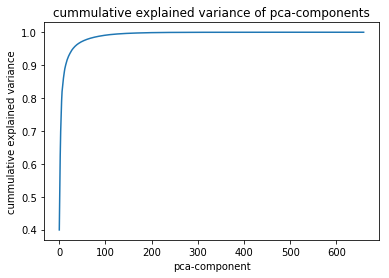

In [38]:
# plot of cummulative explained variance of pca-components
cummulative_explained_variance=np.cumsum(explained_variance)

plt.figure()
plt.plot(cummulative_explained_variance)
plt.xlabel('pca-component')
plt.ylabel('cummulative explained variance')
plt.title('cummulative explained variance of pca-components')
plt.show()

In [39]:
# number of pca-components required to explain 90% variance 
print('{} pca-components are needed to explain {} variance in the data.'.format(
    np.where(cummulative_explained_variance>0.9)[0][0], '90%'))


print('{} pca-components are needed to explain {} variance in the data.'.format(
    np.where(cummulative_explained_variance>0.95)[0][0], '95%'))

print('{} pca-components are needed to explain {} variance in the data.'.format(
    np.where(cummulative_explained_variance>0.99)[0][0], '99%'))

print('{} pca-components are needed to explain {} variance in the data.'.format(
    np.where(cummulative_explained_variance>0.9999)[0][0], '99.99%'))

14 pca-components are needed to explain 90% variance in the data.
30 pca-components are needed to explain 95% variance in the data.
95 pca-components are needed to explain 99% variance in the data.
337 pca-components are needed to explain 99.99% variance in the data.


We see that the cummulative explained variance plateaus off very quickly with only 95 components required to explain 99% of the variance while 337 features are required to explain 99.99% variance.This is a huge jump.For the time being, we will only keep 95 pca-components in our processed feature set. 

In [40]:
num_components=95
pca=PCA(n_components=num_components)

In [41]:
pca_features_train=pca.fit_transform(numerical_features_train)

## Rescaling 2

In [42]:
from sklearn.preprocessing import StandardScaler

In [43]:
scaler2=StandardScaler()

In [44]:
scaled_pca_features_train=scaler2.fit_transform(pca_features_train)

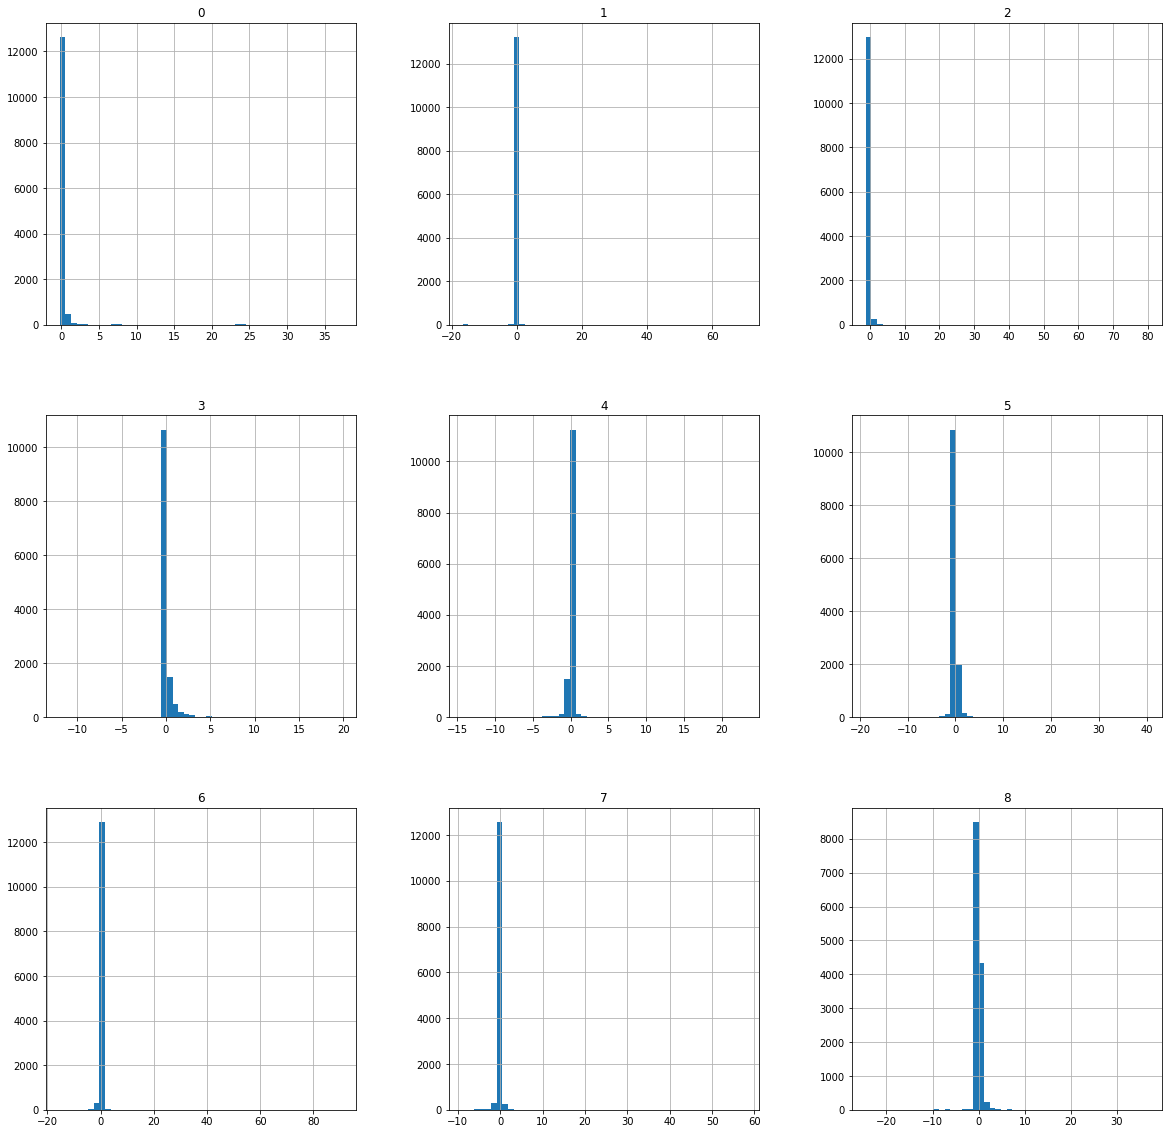

In [45]:
pd.DataFrame(scaled_pca_features_train).hist(bins=50, column=np.arange(0,9), figsize=(20,20), sharex=False, sharey=False)
plt.show()

In [46]:
pd.DataFrame(scaled_pca_features_train).head()

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,-0.179701,0.009961,0.018680,-0.241925,-0.051247,-0.104982,0.020461,-0.029649,-0.267461,-0.287226,...,-0.124997,0.338920,0.110115,0.669044,-0.485518,-0.317088,-0.398062,-0.871926,-0.350036,1.381797
1,0.131955,-0.006010,0.451868,0.869307,-0.423998,0.221141,-0.220567,-0.567021,0.630567,0.293446,...,-1.095594,0.028198,-0.732641,0.466135,-0.682243,0.186570,-0.518157,3.110622,-0.043556,4.722059
2,-0.152948,0.001971,-0.079920,-0.263225,0.080861,-0.098928,0.139703,0.042661,-0.118531,0.113158,...,-0.078380,-0.210395,-0.009173,-0.096354,-0.146855,0.047556,0.043457,0.040732,0.094334,-0.089065
3,-0.204473,0.012603,-0.075388,-0.346228,0.003760,-0.099576,0.024324,0.057431,-0.200409,-0.164400,...,0.126702,-0.191930,-0.198654,-0.177309,-0.138617,-0.177024,0.095755,0.195955,0.170157,-0.182432
4,-0.193070,0.012676,-0.082632,-0.332986,0.007957,-0.106781,0.038871,0.218875,-0.073477,-0.203524,...,-0.073044,-0.054925,0.090928,-0.127077,0.204327,-0.185051,0.197422,0.009559,0.041846,0.114911


In [47]:
pd.DataFrame(scaled_pca_features_train).shape

(13267, 95)

## Preprocessing Pipeline

In [48]:
from sklearn.pipeline import make_pipeline

In [49]:
num_components=95
pipe=make_pipeline(MinMaxScaler(),PCA(n_components=num_components), StandardScaler() )

In [50]:
scaled_pca_features_train=pipe.fit_transform(numerical_features_train)
scaled_pca_features_val=pipe.transform(numerical_features_val)

In [51]:
index_train=X_train.index
scaled_pca_features_train=pd.DataFrame(scaled_pca_features_train, index=index_train)
scaled_pca_features_train.head()

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
f3629e8144732bae,-0.206298,-1.239237,0.767430,1.377085,-0.743836,-0.284856,2.116548,-0.841679,-0.081864,-2.843083,...,0.481546,0.141920,-0.191398,-0.408683,1.681471,-0.716651,-1.481711,0.737683,1.073228,0.691511
43afee34823e74bc,1.557937,0.043652,0.129106,1.286655,0.664309,1.947536,0.235635,1.781378,0.006725,-1.149825,...,1.438598,0.396967,-2.332981,-2.013722,-2.927003,0.093244,0.439227,-0.784149,0.532210,1.423678
74175581ad94ed01,-1.307378,0.059290,-0.013540,0.226003,0.433436,-0.060588,-0.633077,0.593424,-0.560841,0.442492,...,0.221730,-0.000852,-0.009196,-0.293892,0.161729,-0.553239,-0.147475,0.238633,-0.228426,0.099658
6d62a96307f8910d,-0.561762,-0.572244,1.183711,-0.953196,-0.271449,-0.045389,0.401968,0.570196,0.391686,-0.378865,...,-0.376185,0.220514,-0.281062,1.191809,-0.302603,-0.529277,-0.793533,-0.584309,-1.550966,1.232335
9f69fb7bd648410c,-1.310214,0.062435,0.062786,0.201395,0.452596,-0.016613,-0.666038,0.481166,-0.262644,-0.085035,...,-0.444783,-0.297234,-0.098188,-0.209047,0.295565,0.377933,-0.104975,-0.048007,-0.328163,0.214302


In [52]:
pd.DataFrame(scaled_pca_features_train).shape

(13267, 95)

In [54]:
# categorical features in X_train 
categorical_train=X_train.iloc[:,660:]

In [55]:
categorical_train.head(2)

,title_Bird Measurer (Assessment),title_Cart Balancer (Assessment),title_Cauldron Filler (Assessment),title_Chest Sorter (Assessment),title_Mushroom Sorter (Assessment)
f3629e8144732bae,0,1,0,0,0
43afee34823e74bc,0,1,0,0,0


In [83]:
train_features_final=pd.concat([scaled_pca_features_train, categorical_train], axis=1)
train_features_final.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,title_Bird Measurer (Assessment),title_Cart Balancer (Assessment),title_Cauldron Filler (Assessment),title_Chest Sorter (Assessment),title_Mushroom Sorter (Assessment)
f3629e8144732bae,-0.206298,-1.239237,0.767430,1.377085,-0.743836,-0.284856,2.116548,-0.841679,-0.081864,-2.843083,...,-0.716651,-1.481711,0.737683,1.073228,0.691511,0,1,0,0,0
43afee34823e74bc,1.557937,0.043652,0.129106,1.286655,0.664309,1.947536,0.235635,1.781378,0.006725,-1.149825,...,0.093244,0.439227,-0.784149,0.532210,1.423678,0,1,0,0,0
74175581ad94ed01,-1.307378,0.059290,-0.013540,0.226003,0.433436,-0.060588,-0.633077,0.593424,-0.560841,0.442492,...,-0.553239,-0.147475,0.238633,-0.228426,0.099658,0,0,1,0,0
6d62a96307f8910d,-0.561762,-0.572244,1.183711,-0.953196,-0.271449,-0.045389,0.401968,0.570196,0.391686,-0.378865,...,-0.529277,-0.793533,-0.584309,-1.550966,1.232335,0,0,0,0,1
9f69fb7bd648410c,-1.310214,0.062435,0.062786,0.201395,0.452596,-0.016613,-0.666038,0.481166,-0.262644,-0.085035,...,0.377933,-0.104975,-0.048007,-0.328163,0.214302,0,1,0,0,0


In [89]:
# rename the columns the train_features_val to be integers starting from 0
# a good solution is as provided by Jeff Hernandez at the following stack exchange post:
# https://stackoverflow.com/questions/42284617/reset-column-index-pandas

# create a dictionary of old_column_name: new_column_name
rename_dict=dict(map(reversed, enumerate(train_features_final.columns)))


# use rename_dict to rename columns of train_features_final
train_features_final.rename(columns=rename_dict, inplace=True)
train_features_final.head(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
f3629e8144732bae,-0.206298,-1.239237,0.767430,1.377085,-0.743836,-0.284856,2.116548,-0.841679,-0.081864,-2.843083,...,-0.716651,-1.481711,0.737683,1.073228,0.691511,0,1,0,0,0
43afee34823e74bc,1.557937,0.043652,0.129106,1.286655,0.664309,1.947536,0.235635,1.781378,0.006725,-1.149825,...,0.093244,0.439227,-0.784149,0.532210,1.423678,0,1,0,0,0


In [65]:
y_train_true.head()

,accuracy_grp
game_session,
f3629e8144732bae,3
43afee34823e74bc,0
74175581ad94ed01,2
6d62a96307f8910d,0
9f69fb7bd648410c,3


In [53]:
index_val=X_val.index
scaled_pca_features_val=pd.DataFrame(scaled_pca_features_val, index=index_val)
scaled_pca_features_val.head()

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
22f05e5110d38d2d,0.311057,2.886620,0.259841,-1.546751,1.559605,-1.343121,2.066223,0.176223,-0.181928,0.002377,...,0.302568,0.323897,0.164651,-0.008228,0.302370,0.284051,-0.301362,0.046782,-0.112153,-0.273045
1bd873bbc1ed2a35,-1.326259,0.099023,0.037204,0.152505,0.423315,-0.045779,-0.762823,0.285717,0.235528,-0.519658,...,-0.047646,-0.131732,0.046792,-0.115718,0.139050,0.045131,-0.090554,0.300110,0.164293,-0.074510
8fbbaee38ad4cdb3,-1.332978,0.091178,0.044443,0.120648,0.425773,-0.035957,-0.810220,0.214237,0.292544,-0.677427,...,0.071407,-0.105399,0.010995,-0.204679,0.009369,0.044470,0.035166,0.040188,0.043093,0.014322
284cc1b29d643dda,-1.300359,0.065633,-0.016560,0.308717,0.400067,-0.043972,-0.510680,0.651767,-0.212209,0.407495,...,0.313997,0.159380,-0.381753,0.505875,0.816586,0.892174,0.454264,-0.897041,-0.244086,0.207751
4567fa48543bdac7,1.933510,0.572135,0.149222,-0.597945,2.759377,0.442547,-1.048333,0.074623,0.426894,-0.207543,...,-0.235785,0.335434,0.091042,0.025762,-0.107154,-0.181483,-1.112454,-0.552614,0.414094,0.087055


In [56]:
# categorical features in X_val
categorical_val=X_val.iloc[:,660:]
categorical_val.head(2)

,title_Bird Measurer (Assessment),title_Cart Balancer (Assessment),title_Cauldron Filler (Assessment),title_Chest Sorter (Assessment),title_Mushroom Sorter (Assessment)
22f05e5110d38d2d,0,1,0,0,0
1bd873bbc1ed2a35,1,0,0,0,0


In [58]:
val_features_final=pd.concat([scaled_pca_features_val, categorical_val], axis=1)
val_features_final.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,title_Bird Measurer (Assessment),title_Cart Balancer (Assessment),title_Cauldron Filler (Assessment),title_Chest Sorter (Assessment),title_Mushroom Sorter (Assessment)
22f05e5110d38d2d,0.311057,2.886620,0.259841,-1.546751,1.559605,-1.343121,2.066223,0.176223,-0.181928,0.002377,...,0.284051,-0.301362,0.046782,-0.112153,-0.273045,0,1,0,0,0
1bd873bbc1ed2a35,-1.326259,0.099023,0.037204,0.152505,0.423315,-0.045779,-0.762823,0.285717,0.235528,-0.519658,...,0.045131,-0.090554,0.300110,0.164293,-0.074510,1,0,0,0,0
8fbbaee38ad4cdb3,-1.332978,0.091178,0.044443,0.120648,0.425773,-0.035957,-0.810220,0.214237,0.292544,-0.677427,...,0.044470,0.035166,0.040188,0.043093,0.014322,0,1,0,0,0
284cc1b29d643dda,-1.300359,0.065633,-0.016560,0.308717,0.400067,-0.043972,-0.510680,0.651767,-0.212209,0.407495,...,0.892174,0.454264,-0.897041,-0.244086,0.207751,0,0,0,0,1
4567fa48543bdac7,1.933510,0.572135,0.149222,-0.597945,2.759377,0.442547,-1.048333,0.074623,0.426894,-0.207543,...,-0.181483,-1.112454,-0.552614,0.414094,0.087055,0,1,0,0,0


In [90]:
# use the previously defined rename_dict to rename the columns of val_features_final
val_features_final.rename(columns=rename_dict, inplace=True)
val_features_final.head(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
22f05e5110d38d2d,0.311057,2.886620,0.259841,-1.546751,1.559605,-1.343121,2.066223,0.176223,-0.181928,0.002377,...,0.284051,-0.301362,0.046782,-0.112153,-0.273045,0,1,0,0,0
1bd873bbc1ed2a35,-1.326259,0.099023,0.037204,0.152505,0.423315,-0.045779,-0.762823,0.285717,0.235528,-0.519658,...,0.045131,-0.090554,0.300110,0.164293,-0.074510,1,0,0,0,0


In [67]:
y_val_true.head()

,accuracy_grp
game_session,
22f05e5110d38d2d,3
1bd873bbc1ed2a35,1
8fbbaee38ad4cdb3,3
284cc1b29d643dda,0
4567fa48543bdac7,3


In [59]:
print('shape of train_features_final: {}'.format(train_features_final.shape))
print('shape of val_features_final: {}'.format(val_features_final.shape))

shape of train_features_final: (13267, 100)
shape of val_features_final: (4423, 100)


In [69]:
print('shape of y_train_true: {}'.format(y_train_true.shape))
print('shape of y_val_true: {}'.format(y_val_true.shape))

shape of y_train_true: (13267, 1)
shape of y_val_true: (4423, 1)


# Machine Learning Model

## metric Function

The evaluation metric to be used by the competition sponsors is the [quadratic weighted kappa](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps). As has also been mentioned in [this](https://www.kaggle.com/carlolepelaars/understanding-the-metric-quadratic-weighted-kappa) kaggle kernel, this can be obtained from scikit-learn's [cohen_kappa_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html) by passing 'quadratic' for its 'weights' parameter.

However, scikit-learn's implementation is quite slow. A [faster solution](https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-657027) has been provided by Kaggle Grandmaster CPMP. For the time being we will just copy this fast implementation.

In [60]:
from numba import jit

@jit
def qwk3(a1, a2, max_rat):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e

## Classifier

### CatBoostClassifier

As suggested in [this](https://www.kaggle.com/braquino/catboost-some-more-features) kernel, CatBoostClassifier seems to be quite good. Let's try it!

See [this](https://www.kaggle.com/mitribunskiy/tutorial-catboost-overview) extemely good tutorial for getting started with CatBoostClassifier

In [112]:
from catboost import CatBoostClassifier

In [120]:
# CatBoost needs us specify which features are categorical in out data
# for e.g. see In[12] of https://www.kaggle.com/mitribunskiy/tutorial-catboost-overview
# for us these are the last five columns in our data
categorical_features=train_features_final.columns[-1:-6:-1]
categorical_features

Int64Index([99, 98, 97, 96, 95], dtype='int64')

In [125]:
# parameter specification for CatBoostClassifier
params={'loss_function':'MultiClass', 
            'eval_metric': 'WKappa', 
            'iterations':500,
            'verbose': 100, # => display results after every 100 iterations 
            'cat_features': categorical_features,
            'random_seed':42
           }
           


model = CatBoostClassifier(**params) 

In [126]:
model.fit(train_features_final, y_train_true, eval_set= (val_features_final, y_val_true) )

0:	learn: 0.4337050	test: 0.4504433	best: 0.4504433 (0)	total: 1.01s	remaining: 8m 23s
100:	learn: 0.4961252	test: 0.4822236	best: 0.4884883 (75)	total: 1m 44s	remaining: 6m 52s
200:	learn: 0.5184775	test: 0.4953668	best: 0.4961818 (197)	total: 3m 32s	remaining: 5m 15s
300:	learn: 0.5338071	test: 0.5053198	best: 0.5059586 (299)	total: 5m 18s	remaining: 3m 30s
400:	learn: 0.5450036	test: 0.5031714	best: 0.5072491 (311)	total: 7m 2s	remaining: 1m 44s
499:	learn: 0.5560529	test: 0.5029675	best: 0.5072491 (311)	total: 8m 48s	remaining: 0us

bestTest = 0.5072490666
bestIteration = 311

Shrink model to first 312 iterations.


### N-fold cross validation

In [131]:
from catboost import cv, Pool

In [132]:
train_pool= Pool(data=train_features_final, 
                 label=y_train_true, 
                 cat_features=categorical_features)

In [133]:
cv(pool=train_pool, params=params, fold_count=4, 
   shuffle=True, stratified=True)

0:	learn: 0.4339360	test: 0.4282502	best: 0.4282502 (0)	total: 3.75s	remaining: 31m 12s
100:	learn: 0.4919472	test: 0.4770902	best: 0.4786397 (94)	total: 6m 58s	remaining: 27m 33s
200:	learn: 0.5223546	test: 0.4959718	best: 0.4967712 (194)	total: 14m 23s	remaining: 21m 25s
300:	learn: 0.5406168	test: 0.5042785	best: 0.5046352 (299)	total: 22m 26s	remaining: 14m 50s
400:	learn: 0.5553123	test: 0.5099050	best: 0.5113409 (391)	total: 30m 15s	remaining: 7m 28s
499:	learn: 0.5686540	test: 0.5121680	best: 0.5121680 (499)	total: 37m 46s	remaining: 0us


,iterations,test-WKappa-mean,test-WKappa-std,train-WKappa-mean,train-WKappa-std,test-MultiClass-mean,test-MultiClass-std,train-MultiClass-mean,train-MultiClass-std
0,0,0.428250,0.034222,0.433936,0.024301,-1.366046,0.000481,-1.365768,0.000718
1,1,0.456124,0.029264,0.457256,0.011559,-1.346921,0.000924,-1.346455,0.001186
2,2,0.458007,0.024601,0.460767,0.007269,-1.328999,0.001074,-1.328321,0.001285
3,3,0.465148,0.024517,0.467846,0.004790,-1.311744,0.001426,-1.310822,0.001151
4,4,0.464657,0.028199,0.467526,0.006422,-1.297182,0.001736,-1.295899,0.001230
5,5,0.464920,0.030319,0.468314,0.006747,-1.283003,0.002192,-1.281447,0.001428
6,6,0.462632,0.030797,0.467041,0.007254,-1.271110,0.002356,-1.269249,0.001526
7,7,0.463084,0.030572,0.468498,0.006394,-1.258954,0.002983,-1.256829,0.001345
8,8,0.465359,0.027450,0.469780,0.007137,-1.247771,0.003230,-1.245502,0.001449
9,9,0.463926,0.026447,0.470284,0.007749,-1.236983,0.003495,-1.234397,0.001482
